In [3]:
import gzip
from collections import defaultdict
import numpy as np

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)

for user,book,r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  userRatings[user].append(r)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

predictions = open("predictions_Rating.csv", 'w')
for l in open("pairs_Rating.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if u in userAverage:
    predictions.write(u + ',' + b + ',' + str(userAverage[u]) + '\n')
  else:
    predictions.write(u + ',' + b + ',' + str(globalAverage) + '\n')

predictions.close()

### Would-read baseline: just rank which books are popular and which are not, and return '1' if a book is among the top-ranked

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
  bookCount[book] += 1
  totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalRead/2: break

predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if b in return1:
    predictions.write(u + ',' + b + ",1\n")
  else:
    predictions.write(u + ',' + b + ",0\n")

predictions.close()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store data
users = []
books = []
ratings = []

# Read data from the CSV file
for user, book, rating in readCSV("train_Interactions.csv.gz"):
    users.append(user)
    books.append(book)
    ratings.append(float(rating))

# Convert lists to NumPy arrays
users_array = np.array(users)
books_array = np.array(books)
ratings_array = np.array(ratings)

# Count frequencies for ratings
unique_ratings, rating_counts = np.unique(ratings_array, return_counts=True)

# Count frequencies for users
unique_users, user_counts = np.unique(users_array, return_counts=True)

# Count frequencies for books
unique_books, book_counts = np.unique(books_array, return_counts=True)

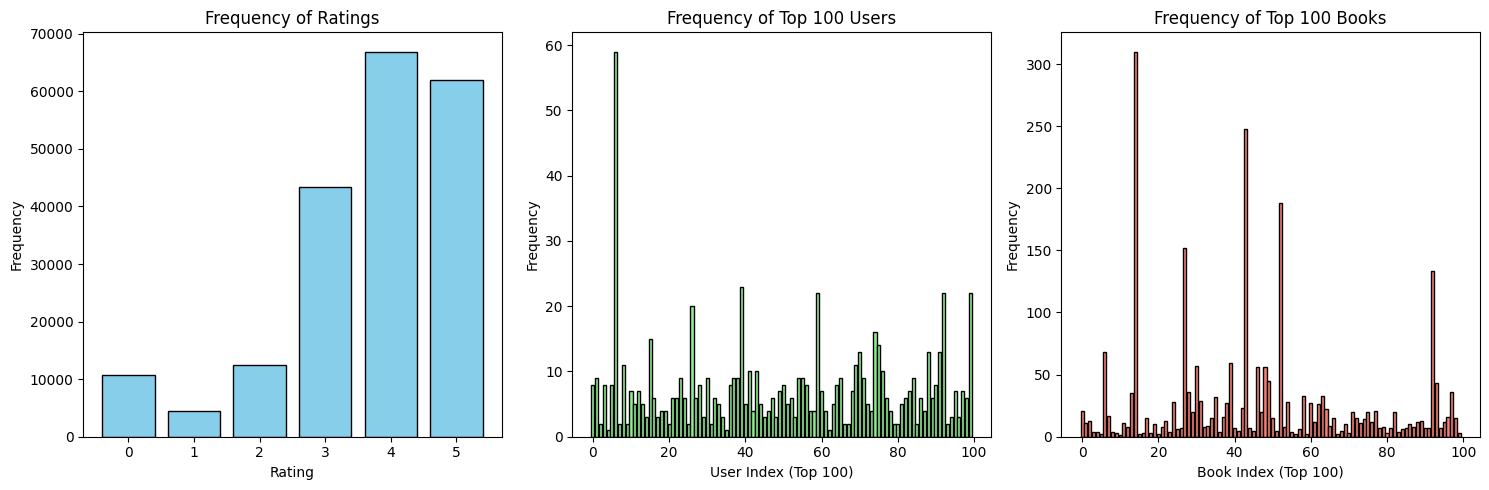

In [10]:
# Plot for ratings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(unique_ratings, rating_counts, color='skyblue', edgecolor='black')
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(unique_ratings)  # Set x-ticks to unique ratings

# Plot for users (show top 10 users for clarity)
top_users = unique_users[:100]
top_user_counts = user_counts[:100]
plt.subplot(1, 3, 2)
plt.bar(range(len(top_users)), top_user_counts, color='lightgreen', edgecolor='black')
plt.title('Frequency of Top 100 Users')
plt.xlabel('User Index (Top 100)')
plt.ylabel('Frequency')

# Plot for books (show top 10 books for clarity)
top_books = unique_books[:100]
top_book_counts = book_counts[:100]
plt.subplot(1, 3, 3)
plt.bar(range(len(top_books)), top_book_counts, color='salmon', edgecolor='black')
plt.title('Frequency of Top 100 Books')
plt.xlabel('Book Index (Top 100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import gzip
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error, accuracy_score # Import sklearn metrics

# Helper function to read the data
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline() # Skip header
    for l in f:
        u,b,r = l.strip().split(',')
        yield u,b,int(r)

# =================================================================
# 1. LOAD AND SPLIT THE DATA
# =================================================================
all_ratings = []
for u, b, r in readCSV("train_Interactions.csv.gz"):
    all_ratings.append((u, b, r))

# Use the same split as the homework
train_set = all_ratings[:190000]
validation_set = all_ratings[190000:]

print(f"Loaded {len(all_ratings)} total interactions.")
print(f"  -> Training set size: {len(train_set)}")
print(f"  -> Validation set size: {len(validation_set)}")

# =================================================================
# 2. "TRAIN" THE PREDICTOR (using ONLY the train_set)
# =================================================================

# Count book frequency *only* in the training set
book_counts_train = defaultdict(int)
for user, book, rating in train_set:
    book_counts_train[book] += 1

# Sort books by popularity
all_books_sorted = sorted(book_counts_train.items(), key=lambda item: item[1], reverse=True)

# Find 50% cutoff
num_unique_books = len(all_books_sorted)
top_50_percent_count = int(num_unique_books * 0.5)

# Create the predictor set
top_50_book_set = set(book_id for book_id, count in all_books_sorted[:top_50_percent_count])

print(f"\nPredictor 'trained' on {len(train_set)} samples.")
print(f"  -> Total unique books in train set: {num_unique_books}")
print(f"  -> Predictor 'top 50%' set contains: {len(top_50_book_set)} books")

# Define the predictor function
def predict_top_50_percent(book_id, top_50_set):
    return 1 if book_id in top_50_set else 0

# =================================================================
# 3. BUILD THE TEST SET (with negative samples)
# =================================================================

# We need all books for negative sampling
all_books_in_data = set(b for u, b, r in all_ratings)
books_per_user = defaultdict(set)
for u, b, r in all_ratings:
    books_per_user[u].add(b)

Loaded 200000 total interactions.
  -> Training set size: 190000
  -> Validation set size: 10000

Predictor 'trained' on 190000 samples.
  -> Total unique books in train set: 6684
  -> Predictor 'top 50%' set contains: 3342 books

Created a test set with 20000 samples.
  -> 10000 positive samples
  -> 10000 negative samples

--- Model Evaluation ---
  sklearn.metrics.mean_squared_error: 0.3061
  sklearn.metrics.accuracy_score:     0.6939 (or 69.39%)

As you can see, accuracy is more interpretable.
This model is correct 69.39% of the time on our test set.


In [12]:
import gzip
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import numpy as np

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline() # Skip header
  for l in f:
    yield l.strip().split(',')

# --- 1. Load and Split Data ---
allRatings_data = []
for user,book,r in readCSV("train_Interactions.csv.gz"):
  allRatings_data.append((user, book, int(r)))

# Split into train/validation
train_set = allRatings_data[:190000]
valid_set = allRatings_data[190000:]

# --- 2. Train Model (on train_set ONLY) ---
allRatings_train = []
userRatings_train = defaultdict(list)

for user, book, r in train_set:
  allRatings_train.append(r)
  userRatings_train[user].append(r)

globalAverage = sum(allRatings_train) / len(allRatings_train)
userAverage = {}
for u in userRatings_train:
  userAverage[u] = sum(userRatings_train[u]) / len(userRatings_train[u])

print("--- Rating Model Evaluation (Regression) ---")
print(f"Model trained on {len(train_set)} samples.")

# --- 3. Test Model (on valid_set) ---
y_true = [] # The actual ratings
y_pred = [] # Our model's predictions

for user, book, r_true in valid_set:
    # 'r_true' is the ground truth
    y_true.append(r_true)
    
    # Predict using the model we just trained
    prediction = userAverage.get(user, globalAverage)
    y_pred.append(prediction)

# --- 4. Calculate MSE ---
mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse}")
print("A lower MSE is better.")

--- Rating Model Evaluation (Regression) ---
Model trained on 190000 samples.
Validation MSE: 1.5896213021406507
A lower MSE is better.


Data loaded.
Calculating user stats (mean and count)...
               mean  count
userID                    
u00000114  3.250000      8
u00000539  3.555556      9
u00002507  3.000000      2
u00004768  4.125000      8
u00005622  3.000000      1
...             ...    ...
u99979525  4.000000      7
u99987325  3.818182     11
u99990398  0.000000     11
u99994553  3.250000      8
u99994977  4.375000      8

[27945 rows x 2 columns]
Plotting...
Plot saved to user_avg_vs_count_scatter.png


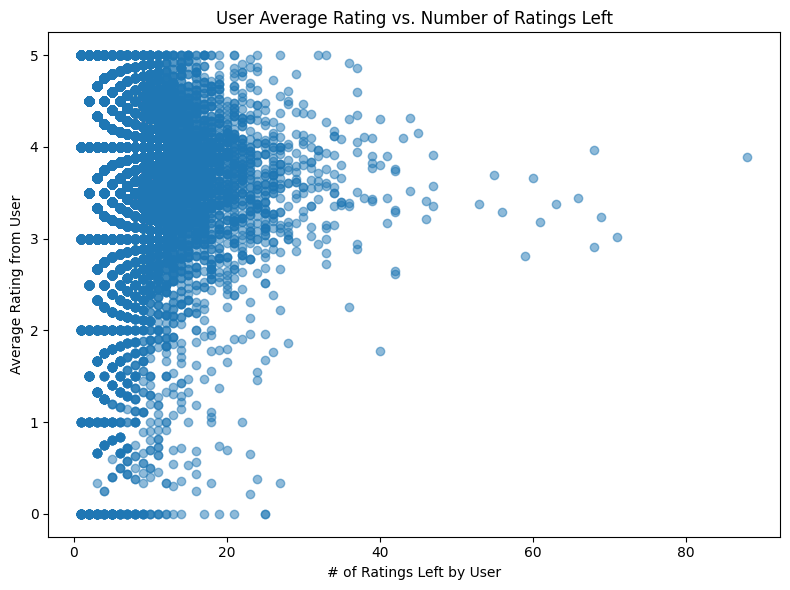

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
import os

# --- 1. Load your data into a pandas DataFrame ---
# We'll use the same augmented snippet as before
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Both Metrics at Once ---
# Group by 'userID', then on the 'rating' column,
# aggregate to get both the 'mean' and the 'count'.
print("Calculating user stats (mean and count)...")
user_stats = df.groupby('userID')['rating'].agg(['mean', 'count'])

# user_stats now looks like this:
#
#            mean  count
# userID                    
# u00402241   1.0      1
# u03186275   1.5      2  <-- This user is (x=2, y=1.5)
# u21322233   3.0      1
# u39455611   5.0      1
# u54531895   3.0      2
# u67805239   4.5      2  <-- This user is (x=2, y=4.5)
# u76549666   4.0      1
# u88999268   0.0      1
# u90502882   4.0      1

print(user_stats)

# --- 3. Create the Scatter Plot ---
print("Plotting...")
plt.figure(figsize=(8, 6))

# X-axis is the 'count' column
# Y-axis is the 'mean' column
plt.scatter(user_stats['count'], user_stats['mean'], alpha=0.5)

plt.title('User Average Rating vs. Number of Ratings Left')
plt.xlabel('# of Ratings Left by User')
plt.ylabel('Average Rating from User')

# When you run this on your full 200,000-line file,
# the x-axis will have a "long tail" (most users have 1-5 ratings,
# a few have 100+). You may want to use a log scale to see it better.
#
# plt.xscale('log') # Uncomment this for the full dataset

# --- 4. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("user_avg_vs_count_scatter.png")
print("Plot saved to user_avg_vs_count_scatter.png")
# plt.show()

Data loaded.
Calculating user stats (mean and count)...

Original Stats:
                mean  count
userID                    
u00000114  3.250000      8
u00000539  3.555556      9
u00002507  3.000000      2
u00004768  4.125000      8
u00005622  3.000000      1
...             ...    ...
u99979525  4.000000      7
u99987325  3.818182     11
u99990398  0.000000     11
u99994553  3.250000      8
u99994977  4.375000      8

[27945 rows x 2 columns]

Normalized Stats:
            mean_normalized  count_normalized
userID                                      
u00000114         0.650000          0.080460
u00000539         0.711111          0.091954
u00002507         0.600000          0.011494
u00004768         0.825000          0.080460
u00005622         0.600000          0.000000
...                    ...               ...
u99979525         0.800000          0.068966
u99987325         0.763636          0.114943
u99990398         0.000000          0.114943
u99994553         0.650000        

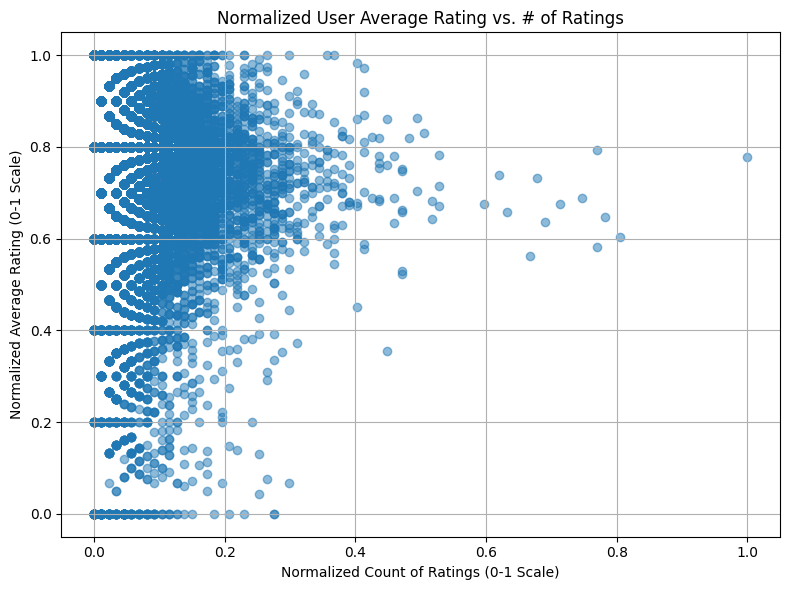

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
from sklearn.preprocessing import MinMaxScaler # <-- Import the scaler

# --- 1. Load your data ---
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Stats ---
print("Calculating user stats (mean and count)...")
user_stats = df.groupby('userID')['rating'].agg(['mean', 'count'])

# user_stats (before scaling):
#            mean  count
# userID                    
# u00402241   1.0      1
# u03186275   1.5      2
# u21322233   3.0      1
# u39455611   5.0      1
# u54531895   3.0      2
# u67805239   4.5      2
# u76549666   4.0      1
# u77777777   3.0      4  <- max count
# u88999268   0.0      1  <- min mean
# u90502882   4.0      1

# --- 3. Normalize the Data (Scale 0-1) ---
scaler = MinMaxScaler()
user_stats_normalized = scaler.fit_transform(user_stats)

# Convert back to a DataFrame for easy plotting
user_stats_norm_df = pd.DataFrame(
    user_stats_normalized, 
    columns=['mean_normalized', 'count_normalized'],
    index=user_stats.index
)

# user_stats_norm_df (after scaling):
#            mean_normalized  count_normalized
# userID                                      
# u00402241             0.20               0.0
# u03186275             0.30               0.33
# u21322233             0.60               0.0
# u39455611             1.00               0.0  <- max mean (5.0) -> 1.0
# u54531895             0.60               0.33
# u67805239             0.90               0.33
# u76549666             0.80               0.0
# u77777777             0.60               1.0  <- max count (4) -> 1.0
# u88999268             0.00               0.0  <- min mean (0.0) -> 0.0
# u90502882             0.80               0.0

print("\nOriginal Stats:\n", user_stats)
print("\nNormalized Stats:\n", user_stats_norm_df)

# --- 4. Create the Normalized Scatter Plot ---
print("Plotting normalized data...")
plt.figure(figsize=(8, 6))

plt.scatter(
    user_stats_norm_df['count_normalized'], 
    user_stats_norm_df['mean_normalized'], 
    alpha=0.5
)

plt.title('Normalized User Average Rating vs. # of Ratings')
plt.xlabel('Normalized Count of Ratings (0-1 Scale)')
plt.ylabel('Normalized Average Rating (0-1 Scale)')
plt.grid(True) # Add grid for easier reading

# --- 5. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("normalized_scatter.png")
print("Plot saved to normalized_scatter.png")
# plt.show()

Data loaded.
Calculating book stats (mean and count)...

Original Stats:
                mean  count
bookID                    
b00013077  3.428571     21
b00054082  2.636364     11
b00083194  4.615385     13
b00114785  4.000000      4
b00158867  4.000000      4
...             ...    ...
b99948252  4.000000      3
b99981162  3.555556      9
b99983531  3.937500     16
b99989469  3.187500     16
b99995068  3.000000     12

[6688 rows x 2 columns]

Normalized Stats:
            mean_normalized  count_normalized
bookID                                      
b00013077         0.685714          0.020555
b00054082         0.527273          0.010277
b00083194         0.923077          0.012333
b00114785         0.800000          0.003083
b00158867         0.800000          0.003083
...                    ...               ...
b99948252         0.800000          0.002055
b99981162         0.711111          0.008222
b99983531         0.787500          0.015416
b99989469         0.637500         

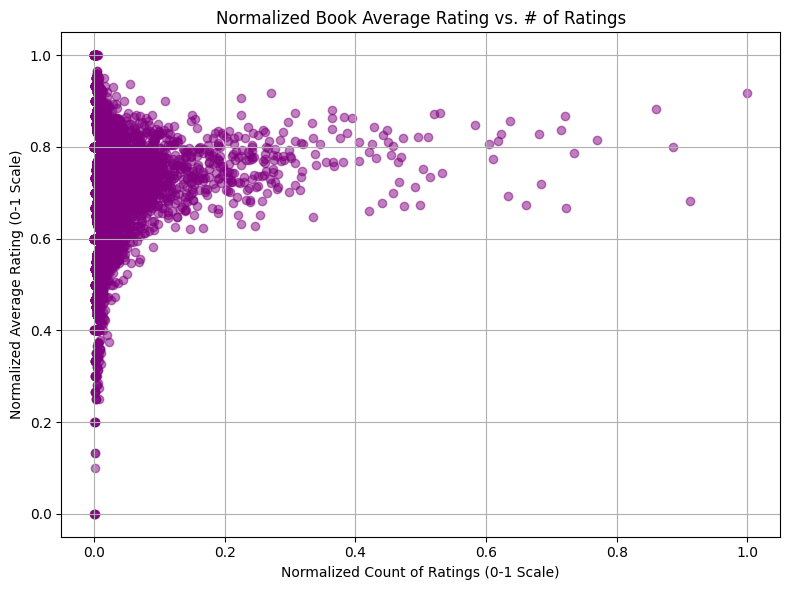

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
from sklearn.preprocessing import MinMaxScaler # Import the scaler

# --- 1. Load your data ---
# We'll use the same augmented snippet as before
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Stats for BOOKS ---
# Group by 'bookID' instead of 'userID'
print("Calculating book stats (mean and count)...")
book_stats = df.groupby('bookID')['rating'].agg(['mean', 'count'])

# book_stats (before scaling):
#             mean  count
# bookID                   
# b00000001   5.0      1
# b00000002   2.0      1
# b00000003   1.0      1
# b01672704   4.0      1
# b09979253   3.0      1
# b23482469   2.0      1
# b40151793   5.0      1
# b49553867   0.0      1
# b61372131   4.0      3  <-- (4+5+3)/3 = 4.0, count = 3
# b66666666   3.0      1
# b68456479   1.0      1
# b75189008   4.0      1
# b75446982   4.0      1
# b77777777   3.0      1
# b88888888   3.0      1
# b99999999   3.0      1

# --- 3. Normalize the Data (Scale 0-1) ---
scaler = MinMaxScaler()
book_stats_normalized = scaler.fit_transform(book_stats)

# Convert back to a DataFrame for easy plotting
book_stats_norm_df = pd.DataFrame(
    book_stats_normalized, 
    columns=['mean_normalized', 'count_normalized'],
    index=book_stats.index
)

print("\nOriginal Stats:\n", book_stats)
print("\nNormalized Stats:\n", book_stats_norm_df)

# --- 4. Create the Normalized Scatter Plot ---
print("Plotting normalized data...")
plt.figure(figsize=(8, 6))

plt.scatter(
    book_stats_norm_df['count_normalized'], 
    book_stats_norm_df['mean_normalized'], 
    alpha=0.5,
    color='purple' # Changed color to distinguish from user plot
)

plt.title('Normalized Book Average Rating vs. # of Ratings')
plt.xlabel('Normalized Count of Ratings (0-1 Scale)')
plt.ylabel('Normalized Average Rating (0-1 Scale)')
plt.grid(True)

# --- 5. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("normalized_book_scatter.png")
print("Plot saved to normalized_book_scatter.png")
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import io

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

def Jaccard(s1, s2):
    """
    Computes Jaccard similarity between two sets.
    """
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

# =================================================================
# TASK 1: RATING PREDICTION (with Vectorized alphaUpdate)
# =================================================================

print("Training the Latent Factor (alpha + beta_u + beta_i) model...")

# --- 1. Read Training Data ---
allRatings = []
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set) 

for user, book, r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  ratingsPerUser[user].append((book, r))
  ratingsPerItem[book].append((user, r))
  usersPerItem[book].add(user)

def alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, lamb):
    """ Update the global bias (alpha) - Vectorized """
    # Map users and books to their current bias values
    # This is much faster than looping and appending
    beta_u_array = np.array([betaU.get(u, 0) for u in users_arr])
    beta_i_array = np.array([betaI.get(b, 0) for b in books_arr])
    
    # NumPy vectorized subtraction and mean
    residuals = ratings_arr - beta_u_array - beta_i_array
    return np.mean(residuals)

def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    """ Update all user biases (beta_u) - Already vectorized """
    newBetaU = {}
    for u in ratingsPerUser:
        items_ratings = ratingsPerUser[u] # List of (item, rating)
        ratings = np.array([r for i, r in items_ratings])
        beta_i_array = np.array([betaI.get(i, 0) for i, r in items_ratings])
        
        numerator = np.sum(ratings - alpha - beta_i_array)
        denominator = len(items_ratings) + lamb
        newBetaU[u] = numerator / denominator
    return newBetaU

def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    """ Update all item biases (beta_i) - Already vectorized """
    newBetaI = {}
    for b in ratingsPerItem:
        users_ratings = ratingsPerItem[b] # List of (user, rating)
        ratings = np.array([r for u, r in users_ratings])
        beta_u_array = np.array([betaU.get(u, 0) for u, r in users_ratings])
        
        numerator = np.sum(ratings - alpha - beta_u_array)
        denominator = len(users_ratings) + lamb
        newBetaI[b] = numerator / denominator
    return newBetaI

# --- 3. Train the Model ---
# Create NumPy arrays *once* outside the loop
train_tuples = [(u, b, r) for u, ratings in ratingsPerUser.items() for b, r in ratings]
ratings_arr = np.array([r for u,b,r in train_tuples])
users_arr = [u for u,b,r in train_tuples] # Keep as list for fast mapping
books_arr = [b for u,b,r in train_tuples] # Keep as list for fast mapping

LAMBDA = 1.0
N_ITERATIONS = 10
alpha = np.mean(allRatings)
betaU = {u: 0 for u in ratingsPerUser}
betaI = {b: 0 for b in ratingsPerItem}

print(f"Iterating {N_ITERATIONS} times...")
for i in range(N_ITERATIONS):
    # Pass the pre-computed NumPy arrays
    alpha = alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, LAMBDA)
    betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, LAMBDA)
    betaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, LAMBDA)
    print(f"  Iteration {i+1}/{N_ITERATIONS} complete.")

print("Rating Model training complete.")


# We also need user/book averages and counts
user_avg = {u: np.mean([r for b,r in ratings]) for u, ratings in ratingsPerUser.items()}
user_count = {u: len(ratings) for u, ratings in ratingsPerUser.items()}
book_avg = {b: np.mean([r for u,r in ratings]) for b, ratings in ratingsPerItem.items()}
book_count = {b: len(ratings) for b, ratings in ratingsPerItem.items()}

# --- 1. Build a Feature Matrix (X) and Target Vector (y) ---
print("Building feature matrix from interaction data...")
# We'll use the original training data as our dataset
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, use this:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))

# Map the features we calculated onto the (user, book) pairs
X = []
y = []

for _, row in df.iterrows():
    u = row['userID']
    b = row['bookID']
    
    # Create the feature vector for this (u, b) pair
    features = [
        betaU.get(u, 0),             # User bias
        betaI.get(b, 0),             # Book bias
        user_avg.get(u, alpha),      # User's average rating
        book_avg.get(b, alpha),      # Book's average rating
        user_count.get(u, 0),        # Num ratings from user
        book_count.get(b, 0)         # Num ratings for book
    ]
    X.append(features)
    y.append(row['rating'])

X = np.array(X)
y = np.array(y)

print(f"Created dataset with X shape: {X.shape} and y shape: {y.shape}")

# --- 2. Train/Test Split and Scaling ---
# We MUST scale data for KNN and SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. KNN + Elbow Plot to find K ---
print("\n--- Starting KNN ---")
print("Finding optimal K (Elbow Plot)...")
k_values = range(1, 10) # Max K should be ~sqrt(len(y_train))
# (For the tiny sample, we'll get errors, so we'll cap K)
k_values = range(1, min(len(y_train), 7)) 
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies.append(acc)

# Plot the elbow
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'o-')
plt.title('Elbow Plot for KNN (Accuracy)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.savefig("knn_elbow.png")
print("Elbow plot saved to knn_elbow.png")

# --- 4. SVM to Predict Rating ---
print("\n--- Starting SVM ---")
print("Training Support Vector Classifier...")
# We use a small 'C' (penalty) and 'rbf' kernel
# This will be VERY slow on 200,000 items. 
# We'll use just a small subset for demonstration.
subset_size = 500 # Use 5000+ for real data
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

svm_model = SVC(C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_subset, y_train_subset)
print("SVM training complete.")

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {svm_accuracy * 100:.2f}%")

# (Note: For the full 200,000 item dataset, SVM will be *extremely* slow
# and memory-intensive. KNN or a simple LogisticRegression is often
# a better choice for a dataset of this size.)

Training the Latent Factor (alpha + beta_u + beta_i) model...


NameError: name 'defaultdict' is not defined

Training the Latent Factor (alpha + beta_u + beta_i) model...
Iterating 10 times...
  Iteration 1/10 complete.
  Iteration 2/10 complete.
  Iteration 3/10 complete.
  Iteration 4/10 complete.
  Iteration 5/10 complete.
  Iteration 6/10 complete.
  Iteration 7/10 complete.
  Iteration 8/10 complete.
  Iteration 9/10 complete.
  Iteration 10/10 complete.
Rating Model training complete.
Building feature matrix from *in-memory* training data...
Created dataset with X shape: (200000, 6) and y shape: (200000,)

--- Starting KNN ---
Finding optimal K (Elbow Plot)...
  Testing K=1...
  Testing K=2...
  Testing K=3...
  Testing K=4...
  Testing K=5...
  Testing K=6...
  Testing K=7...
  Testing K=8...
  Testing K=9...
  Testing K=10...
  Testing K=11...
  Testing K=12...
  Testing K=13...
  Testing K=14...
  Testing K=15...
Elbow plot saved to knn_elbow.png

--- Starting SVM ---
Training Support Vector Classifier...
SVM training complete.
SVM Classification Accuracy: 48.00%


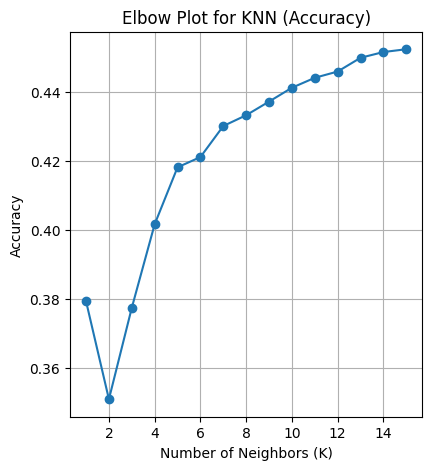

In [8]:
import gzip
from collections import defaultdict
import random
import numpy as np
import os
import string
from sklearn import linear_model
# --- New, efficient imports ---
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

# =================================================================
# HELPER FUNCTIONS
# =================================================================

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

def Jaccard(s1, s2):
    """
    Computes Jaccard similarity between two sets.
    """
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

# =================================================================
# TASK 1: RATING PREDICTION (with Vectorized alphaUpdate)
# =================================================================

print("Training the Latent Factor (alpha + beta_u + beta_i) model...")

# --- 1. Read Training Data ---
allRatings = []
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set) 

for user, book, r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  ratingsPerUser[user].append((book, r))
  ratingsPerItem[book].append((user, r))
  usersPerItem[book].add(user)

# --- 2. Define Model Update Functions ---

# ***** VECTORIZED THIS FUNCTION *****
def alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, lamb):
    """ Update the global bias (alpha) - Vectorized """
    # Map users and books to their current bias values
    # This is much faster than looping and appending
    beta_u_array = np.array([betaU.get(u, 0) for u in users_arr])
    beta_i_array = np.array([betaI.get(b, 0) for b in books_arr])
    
    # NumPy vectorized subtraction and mean
    residuals = ratings_arr - beta_u_array - beta_i_array
    return np.mean(residuals)

def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    """ Update all user biases (beta_u) - Already vectorized """
    newBetaU = {}
    for u in ratingsPerUser:
        items_ratings = ratingsPerUser[u] # List of (item, rating)
        ratings = np.array([r for i, r in items_ratings])
        beta_i_array = np.array([betaI.get(i, 0) for i, r in items_ratings])
        
        numerator = np.sum(ratings - alpha - beta_i_array)
        denominator = len(items_ratings) + lamb
        newBetaU[u] = numerator / denominator
    return newBetaU

def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    """ Update all item biases (beta_i) - Already vectorized """
    newBetaI = {}
    for b in ratingsPerItem:
        users_ratings = ratingsPerItem[b] # List of (user, rating)
        ratings = np.array([r for u, r in users_ratings])
        beta_u_array = np.array([betaU.get(u, 0) for u, r in users_ratings])
        
        numerator = np.sum(ratings - alpha - beta_u_array)
        denominator = len(users_ratings) + lamb
        newBetaI[b] = numerator / denominator
    return newBetaI

# --- 3. Train the Model ---
# Create NumPy arrays *once* outside the loop
train_tuples = [(u, b, r) for u, ratings in ratingsPerUser.items() for b, r in ratings]
ratings_arr = np.array([r for u,b,r in train_tuples])
users_arr = [u for u,b,r in train_tuples] # Keep as list for fast mapping
books_arr = [b for u,b,r in train_tuples] # Keep as list for fast mapping

LAMBDA = 1.0
N_ITERATIONS = 10
alpha = np.mean(allRatings)
betaU = {u: 0 for u in ratingsPerUser}
betaI = {b: 0 for b in ratingsPerItem}

print(f"Iterating {N_ITERATIONS} times...")
for i in range(N_ITERATIONS):
    # Pass the pre-computed NumPy arrays
    alpha = alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, LAMBDA)
    betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, LAMBDA)
    betaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, LAMBDA)
    print(f"  Iteration {i+1}/{N_ITERATIONS} complete.")

print("Rating Model training complete.")
# We also need user/book averages and counts
user_avg = {u: np.mean([r for b,r in ratings]) for u, ratings in ratingsPerUser.items()}
user_count = {u: len(ratings) for u, ratings in ratingsPerUser.items()}
book_avg = {b: np.mean([r for u,r in ratings]) for b, ratings in ratingsPerItem.items()}
book_count = {b: len(ratings) for b, ratings in ratingsPerItem.items()}

# --- 1. Build a Feature Matrix (X) and Target Vector (y) ---
print("Building feature matrix from *in-memory* training data...")

# ***** THIS IS THE FIX *****
# We don't need to re-read the file.
# Just loop over the 'train_tuples' list we already have in memory.
X = []
y = []

# train_tuples already contains all 200,000 (u, b, r) pairs
for u, b, r in train_tuples: 
    
    # Create the feature vector for this (u, b) pair
    features = [
        betaU.get(u, 0),             # User bias
        betaI.get(b, 0),             # Book bias
        user_avg.get(u, alpha),      # User's average rating
        book_avg.get(b, alpha),      # Book's average rating
        user_count.get(u, 0),        # Num ratings from user
        book_count.get(b, 0)         # Num ratings for book
    ]
    X.append(features)
    y.append(r) # 'r' is the rating (our class label)

X = np.array(X)
y = np.array(y)
# ***** END OF FIX *****

print(f"Created dataset with X shape: {X.shape} and y shape: {y.shape}")

# --- 2. Train/Test Split and Scaling ---
# We MUST scale data for KNN and SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. KNN + Elbow Plot to find K ---
print("\n--- Starting KNN ---")
print("Finding optimal K (Elbow Plot)...")
# Use a more reasonable K-range for your large dataset
k_values = range(1, 16) # Let's test K from 1 to 15
accuracies = []

for k in k_values:
    print(f"  Testing K={k}...")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies.append(acc)

# Plot the elbow
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'o-')
plt.title('Elbow Plot for KNN (Accuracy)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig("knn_elbow.png")
print("Elbow plot saved to knn_elbow.png")

# --- 4. SVM to Predict Rating ---
print("\n--- Starting SVM ---")
print("Training Support Vector Classifier...")
# 500 is too small for a 200k dataset. Let's use 10,000.
# WARNING: This will still be VERY SLOW.
subset_size = 10000 
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

svm_model = SVC(C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_subset, y_train_subset)
print("SVM training complete.")

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {svm_accuracy * 100:.2f}%")

In [ ]:
import gzip
from collections import defaultdict
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import trim_mean,kurtosis,zscore,skew,iqr
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# load train_Interactions.csv
train_df = pd.DataFrame()
df = pd.read_csv("train_Interactions.csv")

# convert to memory efficent dtypes
train_df['userID'] = df['userID'].astype('category')
train_df['bookID'] = df['bookID'].astype('category')
train_df['rating'] = df['rating'].astype('float32')

# create features
train_df['user_tmean'] = df.groupby('userID')['rating'].transform(trim_mean,proportiontocut=0.25)
train_df['book_tmean'] = df.groupby('bookID')['rating'].transform(trim_mean,proportiontocut=0.25)
train_df['user_kur'] = df.groupby('userID')['rating'].transform(kurtosis)
train_df['book_kur'] = df.groupby('bookID')['rating'].transform(kurtosis)
train_df['user_skew'] = df.groupby('userID')['rating'].transform(skew,bias=False)
train_df['book_skew'] = df.groupby('bookID')['rating'].transform(skew,bias=False)
train_df['user_zscore'] = df.groupby('userID')['rating'].transform(zscore)
train_df['book_zscore'] = df.groupby('bookID')['rating'].transform(zscore)
train_df['book_high_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x > 3).sum())
train_df['book_mid_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x == 3).sum())
train_df['book_low_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x < 3).sum())
train_df['user_high_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x > 3).sum())
train_df['user_mid_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x == 3).sum())
train_df['user_low_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x < 3).sum())

# define pca numeric features for users and books
numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
    'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
    'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

# define training set for features
X_train = train_df[numeric_features]

# fill all nan features with 0
X_train = X_train.fillna(0)

# standardize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# initalize PCA with 10 components and fit it to the scaled data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 5. Create a new dataframe with PCA components
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=train_df.index
)
# Create a DataFrame of the component "loadings"
loadings_df = pd.DataFrame(
    pca.components_,  # The "function" weights
    columns=numeric_features,  # Your original feature names
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # PC1, PC2, ...
)

# add PCA components to the original dataframe
train_df = pd.concat([train_df, pca_df], axis=1)
#pred_df = train_df.loc[:, 'userID','bookID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
#pred_df = pred_df.reset_index(drop=True)
print("--- PCA Component Loadings (The Custom Function) ---")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")






/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Prec

--- PCA Component Loadings (The Custom Function) ---
Explained variance ratio: [0.23160126 0.18012093 0.14999679 0.11345598 0.10053454 0.06367467
 0.04580236 0.03238147 0.02825591 0.01916857]
Total variance explained: 96.50%


TypeError: read_csv() got an unexpected keyword argument 'index'

In [ ]:
pred_df = pd.read_csv('predictions_Rating.csv')


In [3]:
print(train_df.head())

      userID     bookID  rating  user_tmean  book_tmean  user_kur  book_kur  \
0  u67805239  b61372131     4.0    0.300000    3.570815 -0.873916  0.178353   
1  u54531895  b75189008     4.0    4.000000    4.166667  0.500000 -1.526150   
2  u76549666  b75446982     4.0    3.600000    3.250000 -0.596911 -0.002504   
3  u03186275  b23482469     2.0    2.666667    3.893617 -1.567867  0.517282   
4  u21322233  b09979253     3.0    4.200000    3.666667 -1.020000  0.495767   

   user_skew  book_skew  user_zscore  ...       PC1       PC2       PC3  \
0   1.133893  -0.858846     1.716838  ...  0.061305 -5.225493  1.482633   
1   0.000000  -0.223451     0.000000  ... -1.598512  0.692191  0.099345   
2   0.112748  -0.839772     0.441836  ... -1.892271  0.567713 -0.164851   
3   0.472514  -1.077517    -0.917663  ... -1.358615 -2.412641 -0.752736   
4  -0.689987  -0.776380    -0.948683  ... -0.936545 -0.123695  0.622979   

        PC4       PC5       PC6       PC7       PC8       PC9      PC10  


In [6]:

numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

for index, row in pred_df.iterrows():
    print(f"Index: {index}, Col1: {row['userID']}, Col2: {row['bookID']}")

Index: 0, Col1: u17832892, Col2: b51986055
Index: 1, Col1: u94058414, Col2: b95439113
Index: 2, Col1: u54876772, Col2: b61970919
Index: 3, Col1: u27182378, Col2: b29199360
Index: 4, Col1: u00343094, Col2: b17138341
Index: 5, Col1: u55453694, Col2: b70912031
Index: 6, Col1: u53021409, Col2: b04222499
Index: 7, Col1: u26001504, Col2: b15025576
Index: 8, Col1: u48139087, Col2: b56425922
Index: 9, Col1: u70455688, Col2: b09902724
Index: 10, Col1: u28953105, Col2: b07142228
Index: 11, Col1: u36945000, Col2: b51326446
Index: 12, Col1: u97475837, Col2: b50500341
Index: 13, Col1: u68002923, Col2: b37068431
Index: 14, Col1: u88982175, Col2: b96621963
Index: 15, Col1: u52168464, Col2: b11734216
Index: 16, Col1: u91756228, Col2: b80070869
Index: 17, Col1: u53125666, Col2: b37073691
Index: 18, Col1: u79194318, Col2: b28801125
Index: 19, Col1: u72751138, Col2: b74874001
Index: 20, Col1: u59622201, Col2: b76141146
Index: 21, Col1: u20171277, Col2: b98256804
Index: 22, Col1: u45375749, Col2: b7091203

In [46]:
# List of user-specific features
user_features = [
    'userID', 
    'user_tmean', 
    'user_kur', 
    'user_skew', 
    'user_zscore', 
    'user_high_rating', 
    'user_mid_rating', 
    'user_low_rating'
]

# List of book-specific features
book_features = [
    'bookID', 
    'book_tmean', 
    'book_kur', 
    'book_skew', 
    'book_zscore', 
    'book_high_rating', 
    'book_mid_rating', 
    'book_low_rating'
]

# Create the user lookup table
# (This assumes 'user_tmean' is the same for 'u1' in all rows)
user_stats = train_df[user_features].drop_duplicates(subset=['userID']).set_index('userID')

# Create the book lookup table
book_stats = train_df[book_features].drop_duplicates(subset=['bookID']).set_index('bookID')

In [47]:
# Calculate global averages for all user features
global_user_stats = user_stats.mean()

# Calculate global averages for all book features
global_book_stats = book_stats.mean()

# Combine them into one simple dictionary for filling
global_fill_values = {**global_user_stats, **global_book_stats}

In [48]:
pred_df_features = pred_df.reset_index(drop=True)

# --- Merge ---
# 1. Merge user stats (using 'userID' as the key)
pred_df_features = pred_df_features.merge(
    user_stats, 
    on='userID', 
    how='left'  # 'how=left' keeps every row in pred_df
)

# 2. Merge book stats (using 'bookID' as the key)
pred_df_features = pred_df_features.merge(
    book_stats, 
    on='bookID', 
    how='left'
)

# --- Fill ---
# 3. Fill all NaNs (from cold starts) with the global averages
pred_df_features = pred_df_features.fillna(global_fill_values)

In [58]:

pred_df_features.reset_index(drop=True)
pred_cols = book_features[1:]+user_features[1:]
print(pred_df_features.loc[0,pred_cols].values)

[np.float64(3.9722222222222223) np.float64(0.6221874494077477)
 np.float64(-1.0223930636583478) np.float64(0.9791366586904456)
 np.float64(89.0) np.float64(31.0) np.float64(22.0) np.float64(4.5)
 np.float64(-2.0) np.float64(0.0) np.float64(-1.0) np.float64(4.0)
 np.float64(0.0) np.float64(0.0)]


In [24]:

numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
    'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
    'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

X_train = pred_df_features[numeric_features]
# fill all nan features with 0
X_train = X_train.fillna(0)

# standardize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# initalize PCA with 10 components and fit it to the scaled data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 5. Create a new dataframe with PCA components
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=pred_df_features.index
)
# Create a DataFrame of the component "loadings"
loadings_df = pd.DataFrame(
    pca.components_,  # The "function" weights
    columns=numeric_features,  # Your original feature names
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # PC1, PC2, ...
)

# add PCA components to the original dataframe
#train_df = pd.concat([train_df, pca_df], axis=1)
#pred_df = train_df.loc[:, 'userID','bookID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
#pred_df = pred_df.reset_index(drop=True)
print("--- PCA Component Loadings (The Custom Function) ---")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


--- PCA Component Loadings (The Custom Function) ---
Explained variance ratio: [0.22285696 0.14963252 0.14642143 0.11845089 0.07208357 0.07075118
 0.06230623 0.04543296 0.03303099 0.02892027]
Total variance explained: 94.99%


In [62]:
pca.explained_variance_ratio_.shape
print(loadings_df.shape)

print(X_pca[0,:])

(10, 14)
[ 0.0639656   0.34756833 -0.07915338 -1.52065349 -0.03283073  1.35291754
  0.66782657  0.3611904   0.01252613  0.39343809]


In [25]:
y_train = train_df['rating']
lr = LinearRegression()
lr.fit(X_pca, y_train)

# 4. Get the weights (coefficients) for each PC
weights = lr.coef_
intercept = lr.intercept_

print(f"Weights: {weights}")
print(f"Intercept: {intercept}")

# 5. Make predictions on training set
y_train_pred = lr.predict(X_pca)

# Or manually calculate (should be same as above):
# y_train_pred = intercept + np.sum(X_train_pca * weights, axis=1)
print(y_train_pred.head())
# 6. Calculate MSE on training set
#train_mse = mean_squared_error(y_train, y_train_pred)
#print(f"Training MSE: {train_mse:.4f}")
#print(f"Training RMSE: {np.sqrt(train_mse):.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [10000, 200000]

In [71]:
# 1.1: Load training data
df = pd.read_csv("train_Interactions.csv")
train_df = pd.DataFrame() # Initialize your dataframe
train_df['userID'] = df['userID'].astype('category')
train_df['bookID'] = df['bookID'].astype('category')
train_df['rating'] = df['rating'].astype('float32')

# 1.2: Engineer features for training data
print("Engineering features for training data...")
numeric_features = [
    'user_tmean', 'book_tmean', 'user_kur', 'book_kur', 'user_skew', 
    'book_skew', 'user_zscore', 'book_zscore', 'book_high_rating', 
    'book_mid_rating', 'book_low_rating', 'user_high_rating', 
    'user_mid_rating', 'user_low_rating'
]

# User features
train_df['user_tmean'] = train_df.groupby('userID')['rating'].transform(trim_mean, 0.25)
train_df['user_kur'] = train_df.groupby('userID')['rating'].transform(kurtosis)
train_df['user_skew'] = train_df.groupby('userID')['rating'].transform(skew, bias=False)
train_df['user_zscore'] = train_df.groupby('userID')['rating'].transform(zscore)
train_df['user_high_rating'] = train_df.groupby('userID')['rating'].transform(lambda x: (x > 3).sum())
train_df['user_mid_rating'] = train_df.groupby('userID')['rating'].transform(lambda x: (x == 3).sum())
train_df['user_low_rating'] = train_df.groupby('userID')['rating'].transform(lambda x: (x < 3).sum())

# Book features
train_df['book_tmean'] = train_df.groupby('bookID')['rating'].transform(trim_mean, 0.25)
train_df['book_kur'] = train_df.groupby('bookID')['rating'].transform(kurtosis)
train_df['book_skew'] = train_df.groupby('bookID')['rating'].transform(skew, bias=False)
train_df['book_zscore'] = train_df.groupby('bookID')['rating'].transform(zscore)
train_df['book_high_rating'] = train_df.groupby('bookID')['rating'].transform(lambda x: (x > 3).sum())
train_df['book_mid_rating'] = train_df.groupby('bookID')['rating'].transform(lambda x: (x == 3).sum())
train_df['book_low_rating'] = train_df.groupby('bookID')['rating'].transform(lambda x: (x < 3).sum())

# 1.3: Create final X_train (features) and y_train (target)
X_train = train_df[numeric_features].fillna(0)
y_train = train_df['rating']

# 1.4: Fit the Scaler (Model 1)
print("Fitting StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Use fit_transform here

# 1.5: Fit the PCA (Model 2)
print("Fitting PCA...")
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled) # Use fit_transform here

# 1.6: Fit the Linear Regression (Model 3)
print("Fitting LinearRegression...")
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train)

print(f"Training complete. Model MSE: {mean_squared_error(y_train, lin_reg.predict(X_train_pca)):.4f}")

# --- Part 2: Prepare Test Data ('predictions_Rating.csv') ---

print("\n--- Part 2: Preparing Test Data ---")

# 2.1: Load the test file
pred_df = pd.read_csv('predictions_Rating.csv')

# 2.2: Create the feature lookup tables (this logic was correct!)
user_features = [
    'userID', 'user_tmean', 'user_kur', 'user_skew', 'user_zscore', 
    'user_high_rating', 'user_mid_rating', 'user_low_rating'
]
book_features = [
    'bookID', 'book_tmean', 'book_kur', 'book_skew', 'book_zscore', 
    'book_high_rating', 'book_mid_rating', 'book_low_rating'
]

user_stats = train_df[user_features].drop_duplicates(subset=['userID']).set_index('userID')
book_stats = train_df[book_features].drop_duplicates(subset=['bookID']).set_index('bookID')

global_user_stats = user_stats.mean()
global_book_stats = book_stats.mean()
global_fill_values = {**global_user_stats, **global_book_stats}

# 2.3: Merge features onto the test data
pred_df_features = pred_df.merge(user_stats, on='userID', how='left')
pred_df_features = pred_df_features.merge(book_stats, on='bookID', how='left')

# 2.4: Fill NaNs for cold-start users/books
pred_df_features = pred_df_features.fillna(global_fill_values)

# --- Part 3: Generate Final Predictions ---

print("\n--- Part 3: Generating Predictions ---")

# 3.1: Isolate the features in the *exact same order*
X_test = pred_df_features[numeric_features].fillna(0)

# 3.2: Transform using the *FITTED* Scaler
#      *** DO NOT use fit_transform() here! ***
X_test_scaled = scaler.transform(X_test)

# 3.3: Transform using the *FITTED* PCA
#      *** DO NOT use fit_transform() here! ***
X_test_pca = pca.transform(X_test_scaled)

# 3.4: Predict using the *FITTED* Linear Regression
#      This gives you the final rating predictions
final_predictions = lin_reg.predict(X_test_pca)

# 3.5: Add predictions to your DataFrame
pred_df['predictions'] = final_predictions

# 3.6: (Optional) Add the quartile classification
median_prediction = pred_df['predictions'].median()
pred_df['top_50'] = (pred_df['predictions'] >= median_prediction).astype(int)

print("\n--- Final Predictions ---")
print(pred_df.to_string())

Engineering features for training data...


/tmp/ipykernel_3149360/1498407889.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df['user_tmean'] = train_df.groupby('userID')['rating'].transform(trim_mean, 0.25)
/tmp/ipykernel_3149360/1498407889.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df['user_kur'] = train_df.groupby('userID')['rating'].transform(kurtosis)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(

Fitting StandardScaler...
Fitting PCA...
Fitting LinearRegression...
Training complete. Model MSE: 0.1160

--- Part 2: Preparing Test Data ---

--- Part 3: Generating Predictions ---

--- Final Predictions ---
         userID     bookID  prediction  predictions  top_50
0     u17832892  b51986055    3.973166     3.951677       1
1     u94058414  b95439113    4.543555     4.623794       1
2     u54876772  b61970919    3.949322     3.801761       0
3     u27182378  b29199360    4.416829     4.458356       1
4     u00343094  b17138341    3.795096     3.857076       1
5     u55453694  b70912031    4.181708     4.147576       1
6     u53021409  b04222499    4.467446     4.467492       1
7     u26001504  b15025576    2.322622     2.303537       0
8     u48139087  b56425922    3.849507     3.555318       0
9     u70455688  b09902724    4.087580     4.097952       1
10    u28953105  b07142228    4.090831     4.167283       1
11    u36945000  b51326446    2.546164     2.655700       0
12    u974

In [69]:
print(pred_df.head())
rate_df = pred_df.loc[:,['userID','bookID']]
rate_df['prediction'] = np.clip(pred_df['predictions'],0,5)
print(rate_df.head())


      userID     bookID  prediction  predictions  top_50
0  u17832892  b51986055    4.293379     3.973166       1
1  u94058414  b95439113    3.543131     4.543555       1
2  u54876772  b61970919    4.459285     3.949322       1
3  u27182378  b29199360    3.196524     4.416829       1
4  u00343094  b17138341    2.745816     3.795096       0
      userID     bookID  prediction
0  u17832892  b51986055    3.973166
1  u94058414  b95439113    4.543555
2  u54876772  b61970919    3.949322
3  u27182378  b29199360    4.416829
4  u00343094  b17138341    3.795096


In [70]:
rate_df.to_csv('predictions_Rating.csv',index=False)

In [9]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# 1.1: Load data with pandas
df = pd.read_csv("train_Interactions.csv")

# 1.2: Create a 'Reader' for surprise
# This tells surprise that our ratings are on a 0-5 scale
reader = Reader(rating_scale=(0, 5))

# 1.3: Load the data into surprise's Dataset format
data = Dataset.load_from_df(df[['userID', 'bookID', 'rating']], reader)

# 1.4: (Optional) Do a train/test split for validation
# We can use this to see how well the model is doing
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# 1.5: Instantiate the SVD model
# This model *automatically* includes biases.
# n_factors is the number of latent factors (like N_COMPONENTS)
model = SVD(n_factors=50, n_epochs=30, lr_all= 0.005, reg_all=0.1, random_state=42)

# 1.6: Train the model
print("Training the model...")
model.fit(trainset)

# 1.7: (Optional) Evaluate on the validation test set
predictions = model.test(testset)
val_rmse = accuracy.rmse(predictions)
print(f"Validation RMSE: {val_rmse:.4f}")

# --- Part 2: Train on Full Data & Predict for Submission ---

print("\n--- Part 2: Generating Final Predictions ---")

# 2.1: Create a trainset from the *entire* dataset
print("Retraining on full dataset...")
full_trainset = data.build_full_trainset()
model.fit(full_trainset)

# 2.2: Load the test file
test_df = pd.read_csv('predictions_Rating.csv')

# 2.3: Loop and Predict
# We must predict for each (user, book) pair
final_predictions = []
for index, row in test_df.iterrows():
    uid = row['userID']
    iid = row['bookID']
    
    # model.predict() returns a prediction object
    # The 'est' attribute is the numerical prediction
    # 'r_ui=0' is a dummy value since we don't know the true rating
    pred = model.predict(uid, iid, r_ui=0)
    
    final_predictions.append(pred.est)

Training the model...
RMSE: 1.2117
Validation RMSE: 1.2117

--- Part 2: Generating Final Predictions ---
Retraining on full dataset...


In [10]:

test_df['prediction'] = final_predictions
print(test_df.head())
test_df.to_csv('predictions_Rating.csv',index=False)

      userID     bookID  prediction
0  u17832892  b51986055    4.175062
1  u94058414  b95439113    3.476987
2  u54876772  b61970919    4.139349
3  u27182378  b29199360    3.292445
4  u00343094  b17138341    2.711140


In [7]:
from surprise.model_selection import GridSearchCV

param_grid = {
        'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.1]
}

#Best RMSE score: 1.215783353744208
#Best parameters for RMSE: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}
#Best MAE score: 0.9151097684276364
#Best parameters for MAE: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters for RMSE: {gs.best_params['rmse']}")

print(f"Best MAE score: {gs.best_score['mae']}")
print(f"Best parameters for MAE: {gs.best_params['mae']}")

Best RMSE score: 1.2176774005743212
Best parameters for RMSE: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
Best MAE score: 0.9113046776509174
Best parameters for MAE: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}


In [8]:
print(gs.best_params)

{'rmse': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}}


In [33]:
from scipy.stats import trim_mean

def predictRatingQ7(user, item, ratingMean, reviewsPerUser, usersPerItem, itemsPerUser, userAverages, itemAverages):
    # Your solution here
    k = 5
    mu = ratingMean
    
    # calc user bias
    num_user_reviews = len(reviewsPerUser.get(user, []))
    user_avg = userAverages.get(user, mu)
    b_u_raw = user_avg - mu
    b_u = b_u_raw * (num_user_reviews / (num_user_reviews + k))
    
    # calc item bias
    num_item_raters = len(usersPerItem.get(item, set()))
    item_avg = itemAverages.get(item, mu)
    b_i_raw = item_avg - mu
    b_i = b_i_raw * (num_item_raters / (num_item_raters + k))
    
    # calc final rating
    final_rating = mu + b_u + b_i
    
    return(final_rating)
df2 = pd.read_csv('train_Interactions.csv')
#print(df2.groupby('userID')['rating'].unique_counts())
#print(df2.groupby('bookID')['rating'].value_counts())
print(df2['rating'].value_counts())
#change rating 0 to 1
df2['norm_rating'] = df2['rating']/5

global_mean = df2['norm_rating'].mean()

print(global_mean)

# Calculate user and item average ratings (on the normalized scale)
userAverages = df2.groupby('userID')['norm_rating'].mean().to_dict()
itemAverages = df2.groupby('bookID')['norm_rating'].mean().to_dict()


reviewsPerUser = df2.groupby('userID')['bookID'].apply(list).to_dict()

# Your function uses len(usersPerItem.get(item, set())), so it needs a set.
usersPerItem = df2.groupby('bookID')['userID'].apply(set).to_dict()

# This is required by the function signature, even if not used in the body.
itemsPerUser = df2.groupby('userID')['bookID'].apply(set).to_dict()

print("Pre-computation complete.")


rating
4    66902
5    62039
3    43432
2    12453
0    10778
1     4396
Name: count, dtype: int64
0.7374009999999999
Pre-computation complete.


In [49]:
# load train_Interactions.csv
train_df = pd.DataFrame()
df = pd.read_csv("train_Interactions.csv")

def predictRating_tuned(user, item, ratingMean, reviewsPerUser, usersPerItem,
                        userAverages, itemAverages, k_user=5, k_item=20):
    """
    Predicts a rating using a regularized baseline model.
    """
    mu = ratingMean
    
    # calc user bias with k_user
    num_user_reviews = len(reviewsPerUser.get(user, []))
    user_avg = userAverages.get(user, mu)
    b_u_raw = user_avg - mu
    b_u = b_u_raw * (num_user_reviews / (num_user_reviews + k_user))
    
    # calc item bias with k_item
    num_item_raters = len(usersPerItem.get(item, set()))
    item_avg = itemAverages.get(item, mu)
    b_i_raw = item_avg - mu
    b_i = b_i_raw * (num_item_raters / (num_item_raters + k_item))
    
    # calc final rating
    final_rating = mu + b_u + b_i
    
    return final_rating
df['norm_rating'] = df['rating']/5

ratingMean = df['norm_rating'].mean()

# Calculate user and item average ratings (on the normalized scale)
userAverages = df.groupby('userID')['norm_rating'].mean().to_dict()
itemAverages = df.groupby('bookID')['norm_rating'].mean().to_dict()


reviewsPerUser = df.groupby('userID')['bookID'].apply(list).to_dict()

# Your function uses len(usersPerItem.get(item, set())), so it needs a set.
usersPerItem = df.groupby('bookID')['userID'].apply(set).to_dict()

# This is required by the function signature, even if not used in the body.
itemsPerUser = df.groupby('userID')['bookID'].apply(set).to_dict()

print("Pre-computation complete.")
test_df = pd.read_csv('predictions_Rating.csv.backup')
predictions = []
for _, row in test_df.iterrows():
    user = row['userID']
    item = row['bookID']
    
    pred_norm = predictRating_tuned(user, item, ratingMean, reviewsPerUser, usersPerItem,
                        userAverages, itemAverages, k_user=5, k_item=20)
    predictions.append(pred_norm)


# Add normalized predictions to the DataFrame
test_df['prediction_normalized'] = predictions
# Convert normalized prediction back to the 0-5 scale
test_df['prediction_0_to_5'] = test_df['prediction_normalized'] * 5.0

# Clip the final 0-5 rating to be within the valid range [0, 5]
test_df['prediction'] = test_df['prediction_0_to_5'].clip(lower=0, upper=5)
clean_test_df = test_df.loc[:, ['userID','bookID','prediction']]

clean_test_df.to_csv('predictions_Rating.csv',index=False)

Pre-computation complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

def predictRating_tuned(user, item, ratingMean, reviewsPerUser, usersPerItem,
                        userAverages, itemAverages, k_user=5, k_item=20):
    '''
    Predicts a normalized rating (0-1) using a regularized baseline model.
    '''
    mu = ratingMean
    
    # calc user bias
    num_user_reviews = len(reviewsPerUser.get(user, []))
    user_avg = userAverages.get(user, mu)
    b_u_raw = user_avg - mu
    b_u = b_u_raw * (num_user_reviews / (num_user_reviews + k_user))
    
    # calc item bias
    num_item_raters = len(usersPerItem.get(item, set()))
    item_avg = itemAverages.get(item, mu)
    b_i_raw = item_avg - mu
    b_i = b_i_raw * (num_item_raters / (num_item_raters + k_item))
    
    final_rating = mu + b_u + b_i
    return final_rating

df = pd.read_csv('train_Interactions.csv')
df['norm_rating'] = df['rating']/5

ratingMean = df['norm_rating'].mean()

# Calculate user and item average ratings (on the normalized scale)
userAverages = df.groupby('userID')['norm_rating'].mean().to_dict()
itemAverages = df.groupby('bookID')['norm_rating'].mean().to_dict()


reviewsPerUser = df.groupby('userID')['bookID'].apply(list).to_dict()

# Your function uses len(usersPerItem.get(item, set())), so it needs a set.
usersPerItem = df.groupby('bookID')['userID'].apply(set).to_dict()

# This is required by the function signature, even if not used in the body.
itemsPerUser = df.groupby('userID')['bookID'].apply(set).to_dict()
test_df = pd.read_csv('pairs_Read.csv')
# Add predictions to the DataFrame
test_df['prediction'] = predictions

# Save the predictions to the output file
output_filename = "predictions_Read.csv"
test_df.to_csv(output_filename, index=False)


Engineering features...
Creating training set...
Training Logistic Regression model...
Model training complete.
Loading test data (pairs_Read.csv) and making predictions...
Loaded 20000 test pairs. Building feature set...
Getting raw probabilities from model...
Calibrating threshold based on 50/50 split...
Calculated median threshold: 0.9077


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [35]:
print("\nGenerating predictions for test data...")
predictions = []
for _, row in test_df.iterrows():
    user = row['userID']
    item = row['bookID']
    
    pred_norm = predictRatingQ7(
        user=user,
        item=item,
        ratingMean=global_mean,
        reviewsPerUser=reviewsPerUser,
        usersPerItem=usersPerItem,
        itemsPerUser=itemsPerUser,
        userAverages=userAverages,
        itemAverages=itemAverages
    )
    
    predictions.append(pred_norm)

# Add normalized predictions to the DataFrame
test_df['prediction_normalized'] = predictions

# Convert normalized prediction back to the 0-5 scale
test_df['prediction_0_to_5'] = test_df['prediction_normalized'] * 5.0

# Clip the final 0-5 rating to be within the valid range [0, 5]
test_df['prediction_0_to_5'] = test_df['prediction_0_to_5'].clip(lower=0, upper=5)


Generating predictions for test data...


In [38]:

dff=test_df.loc[:,['userID','bookID','prediction']]
print(dff.head())
dff.to_csv('predictions_Rating.csv',index=False)

      userID     bookID  prediction
0  u17832892  b51986055    4.175062
1  u94058414  b95439113    3.476987
2  u54876772  b61970919    4.139349
3  u27182378  b29199360    3.292445
4  u00343094  b17138341    2.711140


In [89]:
import pandas as pd
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
train_df = pd.read_csv('train_Interactions.csv')
book_counts = train_df['bookID'].value_counts()
train_df['book_count'] = train_df['bookID'].map(book_counts)

totalRead = book_counts.sum()

# 2. Calculate the 50% threshold
threshold = totalRead *0.3

# 3. Get the cumulative sum of reads
# Since book_counts is already sorted descending, this works perfectly
cumulative_counts = book_counts.cumsum()

# 4. Find the bookID that *first* crosses the 50% threshold
# (cumulative_counts > threshold) creates a boolean Series (False, False, ..., True, True, ...)
# .idxmax() finds the index (bookID) of the *first* True value
book_to_stop_at = (cumulative_counts > threshold).idxmax()

# 5. Select all books from the start up to and including that book
# .loc[:label] selects by index label, and it's inclusive
popular_books_series = book_counts.loc[:book_to_stop_at]

# 6. Get the set of bookIDs (your 'return1')
return1 = set(popular_books_series.index)
t= pd.read_csv('pairs_Read.csv')
t['prediction'] = 0
book_to_stop_at = (cumulative_counts > threshold).idxmax()
popular_books_series = book_counts.loc[:book_to_stop_at]
popular_books_set = set(popular_books_series.index)
# --- 2. The New "Power User" Logic ---
# (This is the exact same logic, just for 'userID')
user_counts = train_df['userID'].value_counts()
# totalRead is the same, no need to recalculate
user_threshold = totalRead *.3
user_cumulative_counts = user_counts.cumsum()
user_to_stop_at = (user_cumulative_counts > user_threshold).idxmax()
power_users_series = user_counts.loc[:user_to_stop_at]
power_users_set = set(power_users_series.index)

print(f"Popular books set: {len(popular_books_set)} books")
print(f"Power users set: {len(power_users_set)} users")

# --- 3. Load Test Data and Combine ---
t = pd.read_csv('pairs_Read.csv')

# Create boolean masks for clarity
is_popular_book = t['bookID'].isin(popular_books_set)
is_power_user = t['userID'].isin(power_users_set)

# Combine with OR logic (|)
# This says "predict 1 if *either* condition is True"
t['prediction'] = (is_popular_book | is_power_user).astype(int)

# --- 4. Check results and Save ---
print("\nNew prediction distribution:")
print(t['prediction'].value_counts())

print(t['prediction'].value_counts())

    
t.to_csv('predictions_Read.csv', index=False)
print("Done. File saved to predictions_Read.csv")
"""
print(t.head())
book_counts = train_df['bookID'].value_counts()
user_counts = train_df['userID'].value_counts()
# 2. Map these counts back to the original DataFrame
# The .map() function looks up each bookID in the book_counts Series
# and puts its count into the new column.
train_df['book_count'] = train_df['bookID'].map(book_counts)
train_df['user_count'] = train_df['userID'].map(user_counts)
train_df['metric'] = (train_df['user_count']*train_df['book_count']*train_df['rating'])#+(train_df['user_count']*train_df['rating'])/(train_df['user_count']+train_df['book_count'])
print(train_df[(train_df['book_count']>400)&(train_df['rating']>4)].describe())
gb = train_df[(train_df['book_count']>84)&(train_df['rating']>=4)&(train_df['metric']==5)]['bookID'].value_counts().index
gu = train_df[(train_df['rating']>=5)&(train_df['user_count']>10)]['userID'].value_counts().index
# 1. Initialize the 'prediction' column with 0 for all rows
t['prediction'] = 0

# 2. Now, update the rows that meet your condition to 1
t.loc[t['bookID'].isin(train_df[(train_df['metric']>=10000) & (train_df['rating']>=4)]['bookID'].unique()), 'prediction'] = 1
#t.loc[t['bookID'].isin(train_df[train_df['user_count']>=35]['bookID'].unique()), 'prediction'] = 1
# Now t.describe() will show 0s and 1s
print(t['prediction'].value_counts())
t.to_csv('predictions_Read.csv',index=False)

"""

Popular books set: 181 books
Power users set: 3729 users

New prediction distribution:
prediction
0    12344
1     7656
Name: count, dtype: int64
prediction
0    12344
1     7656
Name: count, dtype: int64
Done. File saved to predictions_Read.csv


"\nprint(t.head())\nbook_counts = train_df['bookID'].value_counts()\nuser_counts = train_df['userID'].value_counts()\n# 2. Map these counts back to the original DataFrame\n# The .map() function looks up each bookID in the book_counts Series\n# and puts its count into the new column.\ntrain_df['book_count'] = train_df['bookID'].map(book_counts)\ntrain_df['user_count'] = train_df['userID'].map(user_counts)\ntrain_df['metric'] = (train_df['user_count']*train_df['book_count']*train_df['rating'])#+(train_df['user_count']*train_df['rating'])/(train_df['user_count']+train_df['book_count'])\nprint(train_df[(train_df['book_count']>400)&(train_df['rating']>4)].describe())\ngb = train_df[(train_df['book_count']>84)&(train_df['rating']>=4)&(train_df['metric']==5)]['bookID'].value_counts().index\ngu = train_df[(train_df['rating']>=5)&(train_df['user_count']>10)]['userID'].value_counts().index\n# 1. Initialize the 'prediction' column with 0 for all rows\nt['prediction'] = 0\n\n# 2. Now, update the r

In [41]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms.predictions import Prediction

df = pd.read_csv('train_Interactions.csv')

reader = Reader(rating_scale=(0, 5))

# Load the DataFrame into a 'Dataset' object
data = Dataset.load_from_df(df[['userID', 'bookID', 'rating']], reader)

print("Data loaded into surprise format.")

# -----------------------------------------------------------------
# 2. Part 1: Run a Simple Cross-Validation
# -----------------------------------------------------------------
print("\n--- Part 1: Running 5-fold CV on default SVD ---")

# Use the SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results
# This will give you the baseline MSE for the SVD model
# We use 'rmse' and 'mae' (mse is just rmse^2)
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
avg_rmse = results['test_rmse'].mean()
print(f"\nDefault SVD results: Avg. RMSE = {avg_rmse:.6f}")
print(f"This is an estimated MSE of: {avg_rmse**2:.6f}")

# -----------------------------------------------------------------
# 3. Part 2: Tune Hyperparameters with GridSearchCV
# -----------------------------------------------------------------
print("\n--- Part 2: Tuning Hyperparameters with GridSearchCV ---")

# Define the grid of parameters to test
# This is where you add your new "hyperparameters"

param_grid = {
    'n_factors': [10],       # Try a *smaller* number of factors
    'n_epochs': [30],                # Lock in your best param
    'lr_all': [0.005],               # Lock in your best param
    'reg_all': [0.1, 0.15, 0.2, 0.3, 0.4] # Search the *lower* regularization
                                     # space that your first grid tested
}
# Note: This is a small grid to run quickly. You can add more values.

# Use GridSearchCV to find the best parameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # Use 3-fold CV for speed
gs.fit(data)

# Print the best score and parameters
print(f"\nGridSearch Complete.")
print(f"Best RMSE score (from grid search): {gs.best_score['rmse']:.6f}")
print(f"Best parameters (from grid search): {gs.best_params['rmse']}")

# -----------------------------------------------------------------
# 4. Part 3: Train Final Model and Make Predictions
# -----------------------------------------------------------------
print("\n--- Part 3: Training Final Model and Predicting ---")

# Get the best algorithm from the grid search
best_algo = gs.best_estimator['rmse']

# Train this algorithm on the *entire* training dataset
# (GridSearchCV already did this, but this is the explicit way)
full_trainset = data.build_full_trainset()
best_algo.fit(full_trainset)


test_df = pd.DataFrame(test_data)

print("\nMaking predictions on test set:")
predictions = []
for _, row in test_df.iterrows():
    user = row['userID']
    item = row['bookID']
    
    # Use the .predict() method
    # This single call does all the work:
    # 1. Fetches global mean (mu)
    # 2. Fetches user bias (bu)
    # 3. Fetches item bias (bi)
    # 4. Fetches user vector (pu) and item vector (qi)
    # 5. Calculates mu + bu + bi + (pu * qi)
    pred = best_algo.predict(uid=user, iid=item)
    
    # 'pred.est' is the estimated rating
    predictions.append(pred.est)

test_df['prediction'] = predictions

# Clip the predictions to be within the 0-5 range
test_df['prediction'] = test_df['prediction'].clip(lower=0, upper=5)

Data loaded into surprise format.

--- Part 1: Running 5-fold CV on default SVD ---
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2197  1.2275  1.2319  1.2232  1.2240  1.2253  0.0041  
MAE (testset)     0.9150  0.9182  0.9241  0.9192  0.9198  0.9193  0.0029  
Fit time          3.25    2.86    2.93    2.83    2.91    2.96    0.15    
Test time         0.24    0.24    0.25    0.25    0.25    0.24    0.00    

Default SVD results: Avg. RMSE = 1.225275
This is an estimated MSE of: 1.501300

--- Part 2: Tuning Hyperparameters with GridSearchCV ---

GridSearch Complete.
Best RMSE score (from grid search): 1.214170
Best parameters (from grid search): {'n_factors': 10, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}

--- Part 3: Training Final Model and Predicting ---


NameError: name 'test_data' is not defined